In [243]:
import gymnasium as gym 
import random
import torch
from torch import nn
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

In [244]:
env=gym.make("LunarLanderContinuous-v2")

#observation space
print(env.observation_space)

#action space
env.action_space

Box([-90.        -90.         -5.         -5.         -3.1415927  -5.
  -0.         -0.       ], [90.        90.         5.         5.         3.1415927  5.
  1.         1.       ], (8,), float32)


Box(-1.0, 1.0, (2,), float32)

In [245]:
class OrnsteinUhlenbeckProcess:
    def __init__(self, theta, mu, sigma, dt, initial_value=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.current_value = initial_value if initial_value is not None else mu

    def sample(self):
        # Generate a sample from the Ornstein-Uhlenbeck process
        dW = np.random.normal(loc=0, scale=np.sqrt(self.dt))
        dx = self.theta * (self.mu - self.current_value) * self.dt + self.sigma * dW
        self.current_value += dx
        return self.current_value
    
class Gaussian_noise:
    def __init__(self,mu=0,var=1):
        mu=mu
        var=var
        
    def sample(self):
        return np.random.normal(0,1)
    
gauss_process=Gaussian_noise()

theta = 0.1
mu = 0.0
sigma = 0.2
dt = 0.01

ou_process = OrnsteinUhlenbeckProcess(theta, mu, sigma, dt)

In [246]:
num_episodes=200
tot_reward=0
for _ in range(num_episodes):

    env.reset()
    terminal=False

    while terminal==False:
        #get a action between (-1,1)--action space
        action=np.random.random(2)
        #take the action
        next_state,reward,terminal,truncated,_=env.step(action)
        tot_reward+=reward

        if truncated==True:
            break

avg_reward=tot_reward/num_episodes
avg_reward

-716.6927670694603

In [247]:
def actor_network():
    return nn.Sequential(
        nn.Linear(8, 16),
        nn.ReLU(),
        nn.Linear(16, 2)
    )

def critic_network():
    return nn.Sequential(
        nn.Linear(10, 16),
        nn.ReLU(),
        nn.Linear(16, 1)
    )

class DDPG:
    def __init__(self, env, process):
        self.env = env
        self.max_buffer_size = 2000
        self.buffer = deque(maxlen=self.max_buffer_size)
        self.critic = critic_network()
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=0.01)
        self.actor = actor_network()
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=0.01)
        self.target_critic =critic_network()
        self.target_actor = actor_network()
        self.batch_size = 16
        self.tau = 0.01
        self.process=process
        
        self.copy_targets(self.target_actor,self.actor)
        self.copy_targets(self.target_critic,self.critic)


    def copy_targets(self, target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)
            
    def update_targets(self, target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def train(self,max_episodes):
        
        arew=[]
        current_state=None
        for i in range(max_episodes):
            
            current_state=env.reset()[0]
            terminal=False

            while terminal==False:
                
                actor_network_output=torch.clamp(self.actor.forward(torch.tensor(current_state)),min=-1,max=1).detach().numpy()
                
                noise=self.process.sample()
                
                # print(noise,actor_network_output)
                
                action=actor_network_output+noise
                
                next_state,reward,terminal,truncated,_=env.step(action)
                
                transition=(current_state,action,reward,next_state)
            
                self.buffer.append(transition)
                current_state=next_state

                if truncated==True:
                    break
                
                if len(self.buffer)<self.batch_size:
                    continue

                sampled_batch = random.sample(self.buffer,self.batch_size)

                targets=[]
                q_s=[]
                d_p_g=torch.tensor([0.])
                for s,a,r,next_state in sampled_batch:
                        
                        s_1=torch.tensor(s)
                        a_0=torch.tensor(a)
                        s_a=torch.cat((s_1,a_0))
                        n_x=torch.tensor(next_state)
                        
                        a_1=torch.clamp(self.target_actor.forward(n_x),min=-1,max=1)
                        
                        y=r+self.target_critic.forward(torch.cat((n_x,a_1)))
                        
                        q=self.critic.forward(s_a)
                        targets.append(y)
                        q_s.append(q)
                
                loss = nn.functional.mse_loss(torch.stack(q_s),torch.stack(targets))    
                self.critic_optimizer.zero_grad()
                loss.backward()
                self.critic_optimizer.step() 
                        
                
                for s,a,r,next_state in sampled_batch:
                     s=torch.tensor(s)
                     a_1=torch.clamp(self.actor.forward(s),min=-1,max=1)
                     
                     q=self.critic.forward(torch.cat((s,a_1)))
                     
                     d_p_g+=q
                     


                d_p_g/=(-self.batch_size)

                self.actor_optimizer.zero_grad()
                
                d_p_g.backward()

                self.actor_optimizer.step()
                

            self.update_targets(self.target_actor,self.actor)
            self.update_targets(self.target_critic,self.critic)
            
            if i%50==0:
                temp=self.avg_reward(100)
                print(temp)
                arew.append(temp)
        return arew   
           
        
    def avg_reward(self,num_episodes):

        tot_reward=0
        for _ in range(num_episodes):

            current_state=env.reset()[0]
            terminal=False
            
            while terminal==False:
                action=torch.clamp(self.actor(torch.tensor(current_state)).detach(),min=-1,max=1).numpy()
                next_state,reward,terminal,truncated,_=env.step(action)

                current_state=next_state
                tot_reward+=reward
                if truncated==True:
                    break

            
        return tot_reward/num_episodes     

In [248]:
model=DDPG(env,ou_process)

In [249]:
avg=model.train(500)

-588.138212114272
-567.0017860590156
-1005.9297372077767
-624.7480992265914
-595.4427679570567
-256.3734560705339
-586.0842162841217
-826.8407143371932
-211.43534885316956
-71.35361590510915


In [250]:
model1=DDPG(env,gauss_process)


In [252]:
avg1=model1.train(500)

-1099.6999473326082
-1110.8745292972992
-1068.778346261481
-1178.9553724629172
-1094.5679071257964
-1100.9439266381805
-1091.5011929228388
-1073.6049160372734
-1079.465411753038
-1093.7924607288273


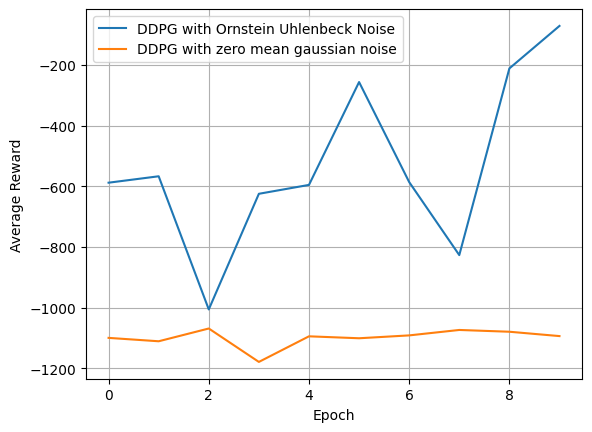

In [254]:
plt.plot(np.arange(10),avg,label="DDPG with Ornstein Uhlenbeck Noise")
plt.plot(np.arange(10),avg1,label="DDPG with zero mean gaussian noise")
plt.grid()
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Reward')
plt.show()